In [42]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import warnings; warnings.simplefilter('ignore')
from time import time
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import SGD, Adam, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import Dropout, Input, Dense,Lambda, BatchNormalization
from sklearn.utils import shuffle
from keras.models import Model,Sequential, load_model
from keras import backend as K
from keras.layers import Embedding, LSTM, concatenate
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

1 Physical GPUs, 1 Logical GPUs


In [43]:
####### Metricas ##########
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

###################### New MEthods ##########
def load_csv_data(url, drop_columns=[]):
    
    #READ data
    print("Loading data")
    df = pd.read_csv(url)
    print("Removing columns",drop_columns)
    df = df.drop(columns=drop_columns)
    return df

def log_targets(y_train, y_val, y_test):
    """ Transform to log scale """
    y_train_log = np.log(y_train)
    y_val_log = np.log(y_val)
    y_test_log = np.log(y_test)

    y_train_log_min = np.min(y_train_log)
    y_train_min = np.min(y_train)

    y_train_log_max = np.max(y_train_log)
    y_train_max = np.max(y_train)

    print("targets min:{} max: {}".format(y_train_min, y_train_max))
    print("targets in log scale min:{} max: {}".format(y_train_log_min, y_train_log_max))
    return y_train_log, y_val_log, y_test_log

def normalize_xdata(x_train, x_val, x_test):
    #Standarización del target
    scaler = StandardScaler()
    x_train_std = scaler.fit_transform(x_train)
    x_val_std = scaler.transform(x_val)
    x_test_std = scaler.transform(x_test)
    return scaler, x_train_std, x_val_std, x_test_std

def normalize_target(train, val, test):
    """
    Normalize data using StandardScaler.
    
    return scaler object; values of train,val and test sets standarized. 
    """
    #Standarización del target
    scaler = StandardScaler()
    y_train_log_std = scaler.fit_transform(train)
    y_val_log_std = scaler.transform(val)
    y_test_log_std = scaler.transform(test)
    return scaler, y_train_log_std, y_val_log_std, y_test_log_std

def get_metrics(model, scaler, x_data, y_true_data, label_set="Data"):
    y_pred = np.exp(scaler.inverse_transform(model.predict(x_data).reshape(-1, 1)))
    rmseval = np.sqrt(mean_squared_error(y_true_data, y_pred))
    r2val = r2_score(y_true_data, y_pred)
    print("RMSE "+label_set, rmseval)
    print("R2 SCORE "+label_set, r2val)
    return rmseval, r2val

def plot_history(history, metrics_list, start_at_epoch=0):
    for metric in metrics_list:
        plt.plot(history.history[metric][start_at_epoch:],label=metric)
    plt.legend()
    plt.title("Metrics by epochs(Start from epoch:{})".format(start_at_epoch))
    plt.show()


In [44]:
#load new data
data_rnn =  pd.read_csv("models_newdata/datasetlsq_output_recurrentfeat.csv", delimiter="ᶶ")
data_rnn = data_rnn.drop(columns="Unnamed: 3")

#Data from files
data_algebra = pd.read_csv("/home/dcasals/graph-edit-distance/data/algebra_features.txt")
data_medoids = pd.read_csv("/home/dcasals/graph-edit-distance/data/vectors_medoids.csv")
result = data_algebra.merge(data_medoids, left_on='query_id', right_on='id')
result = result.drop(columns=["query_id","Unnamed: 27_x", "Unnamed: 27_y"])

nunique = result.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
print("Remove columns with same values: {}".format(cols_to_drop))
result = result.drop(cols_to_drop, axis=1)
new_cols = list(result.columns[:-25]) + ['pcs'+str(i) for i in list(range(0,25))]
result.columns = new_cols
result.columns

Remove columns with same values: Index(['path*', 'pathN*', 'path+', 'pathN+', 'notoneof', 'tolist', 'multi',
       'top', 'assign', 'sequence'],
      dtype='object')


Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'graph',
       'extend', 'minus', 'order', 'project', 'distinct', 'reduced', 'group',
       'slice', 'treesize', 'id', 'time', 'pcs0', 'pcs1', 'pcs2', 'pcs3',
       'pcs4', 'pcs5', 'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11',
       'pcs12', 'pcs13', 'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19',
       'pcs20', 'pcs21', 'pcs22', 'pcs23', 'pcs24'],
      dtype='object')

In [45]:
result = result[['id','triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'time','pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]

In [46]:
data_rnn = data_rnn.merge(result, left_on='id', right_on='id')
data_rnn

,id,tpfs,execTime,triple,bgp,join,leftjoin,union,filter,project,...,pcs15,pcs16,pcs17,pcs18,pcs19,pcs20,pcs21,pcs22,pcs23,pcs24
0,http://lsq.aksw.org/res/DBpedia-q113812,"2,http://www.w3.org/2000/01/rdf-schema#label,1...",4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.400000,0.166667,0.333333,0.500000,0.400000,0.285714,0.200000,0.333333,0.200000,0.200000
1,http://lsq.aksw.org/res/DBpedia-q113813,"9,http://dbpedia.org/property/pushpinMap,",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
2,http://lsq.aksw.org/res/DBpedia-q113814,"9,http://dbpedia.org/property/reference,",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
3,http://lsq.aksw.org/res/DBpedia-q113815,"9,http://www.w3.org/2000/01/rdf-schema#label,9...",4,3.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.333333,0.200000,0.333333,0.333333,0.285714,0.400000,0.200000,0.333333,0.200000,0.200000
4,http://lsq.aksw.org/res/DBpedia-q113817,"9,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.250000,0.181818,0.250000,0.166667,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16956,http://lsq.aksw.org/res/DBpedia-q1014063,"1,http://www.w3.org/2000/01/rdf-schema#label,",55527,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.142857,0.250000,0.400000,0.666667,0.222222,0.166667,0.250000,0.166667,0.166667
16957,http://lsq.aksw.org/res/DBpedia-q1085454,"1,http://dbpedia.org/property/label,",16592,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.666667,0.133333,0.222222,0.400000,0.666667,0.222222,0.166667,0.222222,0.153846,0.153846
16958,http://lsq.aksw.org/res/LGD-q5773,"4,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",3434,6.0,6.0,0.0,3.0,2.0,0.0,1.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000
16959,http://lsq.aksw.org/res/LGD-q5960,"4,http://www.w3.org/1999/02/22-rdf-syntax-ns#t...",3140,6.0,6.0,0.0,3.0,2.0,0.0,1.0,...,0.153846,0.333333,0.333333,0.166667,0.153846,0.250000,0.200000,0.333333,1.000000,1.000000


In [47]:
from keras.utils import to_categorical
def procesar_tpfs_odd(x):
    """Get odd elements from a list """
    lista = []
    for a in x.split(",")[::2]:
        if a != "":
            if a.isdigit():
                lista.append(int(a))
            else:
                lista.append(0)
#     print(lista)
    return lista
def procesar_tpfs_even(x):
    """Get even elements from a list """
    lista  = [a for a in x.split(",")[1::2] if a != ""]
#     print(lista)
    return lista
def uri_2_index_seq(x,uri2Index):
    """transform uris to sequences"""
    lista  = [uri2Index[a] for a in x]
#     print(lista)
    return lista
def get_embedding_matrix_zero(index_dict, EMBEDDING_DIM):
    '''
        Generamos la matriz de embeddings, de dimensiones: 
          - (Tamano_vocabulario + 1) x Dimesion_embedding DecodeInput
    '''
    embedding_matrix = np.zeros((len(index_dict) + 1, EMBEDDING_DIM))
    return embedding_matrix

In [86]:

def build_RNN(num_pred_words, embedd_dim, embedd_type_dim, embedd_input_matrix, embedding_types_matrix, lstm_units, lstm_types_units):
    dropout = 0.25
    lstm_pred_input = Input(shape=(None,),name='lstm_pred_input')
    lstm_pred_embedd = Embedding(num_pred_words + 1 ,embedd_dim, weights=[embedd_input_matrix], trainable=True)(lstm_pred_input)
    lstm_pred_out = LSTM(lstm_units, name='lstm_pred_out')(lstm_pred_embedd)

    # Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_pred_output = Dense(1, activation='linear', name='aux_recurrent_pred_output')(lstm_pred_out)
    
    lstm_type_input = Input(shape=(None,),name='lstm_type_input')
    lstm_type_embedd = Embedding(10 , embedd_type_dim, weights=[embedding_types_matrix], trainable=True)(lstm_type_input)
    lstm_type_out = LSTM(lstm_units, name='lstm_type_out')(lstm_type_embedd)

#     Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_type_output = Dense(1, activation='linear', name='aux_recurrent_type_output')(lstm_type_out)
    
    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = Dense(260, activation='relu')(dense_input)
    x = Dropout(dropout)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(240, activation='relu')(x)
    x = concatenate([lstm_type_out,lstm_pred_out, x])
#     x = concatenate([lstm_type_out, x])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
    model = Model(inputs=[lstm_type_input, lstm_pred_input, dense_input,], outputs=[main_output])
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    return model

def build_RNN3(num_pred_words, embedd_dim, embedd_type_dim, embedd_input_matrix, embedding_types_matrix, lstm_units, lstm_types_units):
    dropout = 0.25
    lstm_pred_input = Input(shape=(None,),name='lstm_pred_input')
    lstm_pred_embedd = Embedding(num_pred_words + 1 ,embedd_dim, weights=[embedd_input_matrix], trainable=True)(lstm_pred_input)
    lstm_pred_out = LSTM(lstm_units, name='lstm_pred_out')(lstm_pred_embedd)

    # Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_pred_output = Dense(1, activation='linear', name='aux_recurrent_pred_output')(lstm_pred_out)
    
#     lstm_type_input = Input(shape=(None,),name='lstm_type_input')
#     lstm_type_embedd = Embedding(10 , embedd_type_dim, weights=[embedding_types_matrix], trainable=True)(lstm_type_input)
#     lstm_type_out = LSTM(lstm_units, name='lstm_type_out')(lstm_type_embedd)

#     Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_type_output = Dense(1, activation='linear', name='aux_recurrent_type_output')(lstm_type_out)
    
    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = Dense(260, activation='relu')(dense_input)
    x = Dropout(dropout)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(240, activation='relu')(x)
    x = concatenate([lstm_pred_out, x])
#     x = concatenate([lstm_type_out, x])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
    model = Model(inputs=[lstm_pred_input, dense_input,], outputs=[main_output])
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
#     from keras.utils import plot_model
#     a = plot_model(model, to_file='model.png')
    return model

def build_RNN2(num_pred_words, embedd_dim, embedd_type_dim, embedd_input_matrix,embedding_types_matrix, lstm_units, lstm_types_units):
    dropout = 0.25
    lstm_pred_input = Input(shape=(None,),name='lstm_pred_input')
    lstm_pred_embedd = Embedding(num_pred_words + 1 ,embedd_dim, weights=[embedd_input_matrix], trainable=True)(lstm_pred_input)
    lstm_pred_out = LSTM(lstm_units, name='lstm_pred_out')(lstm_pred_embedd)

    # Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_pred_output = Dense(1, activation='linear', name='aux_recurrent_pred_output')(lstm_pred_out)
    
    lstm_type_input = Input(shape=(None,),name='lstm_type_input')
    lstm_type_embedd = Embedding(10 , embedd_type_dim, weights=[embedding_types_matrix], trainable=True)(lstm_type_input)
    lstm_type_out = LSTM(lstm_units, name='lstm_type_out')(lstm_type_embedd)

#     Salida Auxiliar del modelo recurrente de predicados
#     aux_recurrent_type_output = Dense(1, activation='linear', name='aux_recurrent_type_output')(lstm_type_out)
    
    dense_input = Input(shape=(34,), name='dense_input')    

    # We stack a deep densely-connected network on top
    x = Dense(260, activation='relu')(dense_input)
    x = Dropout(dropout)(x)
    x = Dense(300, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(240, activation='relu')(x)
    x = concatenate([lstm_type_out, lstm_pred_out])

    # And finally we add the main logistic regression layer
    main_output = Dense(1, activation='linear', name='main_output')(x)
    
    #Build model
    model = Model(inputs=[lstm_type_input, lstm_pred_input,], outputs=[main_output])
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    return model

def build_ANN2():
    dropout = 0.25

    model = Sequential()
    model.add(Dense(260, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(240, activation='relu'))
    model.add(Dense(1, activation='linear'))
#     model = Model(inputs=[lstm_type_input, dense_input,], outputs=[main_output])
    return model

In [49]:
def separar_data(data):
    data = data[data['time'] < 15000]
    tpfs_structure = data['tpfs'].apply(lambda x: procesar_tpfs_odd(x))
    tpfs_predicate = data['tpfs'].apply(lambda x: procesar_tpfs_even(x))
    dense_data = data[['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize','pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24']]
    targets = data[['time']]
    print("columnas: {}".format(dense_data.columns))
    return dense_data.values , tpfs_structure, tpfs_predicate, targets.values

def preprocesar_lstm_data(lstm_pred_data, lstm_type_data, EMBEDDING_DIM_PRED = 200, EMBEDDING_DIM_TYPES=10):
    #create indexes
    index = 1
    uri2Index = {}
    index2Uri = {}

    for lista in  lstm_pred_data.values:
        for val in lista:
            if val not in uri2Index:
                uri2Index[val] = index
                index2Uri[index] = val
                index +=1
    tpfs_pred_index = lstm_pred_data.apply(lambda x: uri_2_index_seq(x, uri2Index))
    
    #Max Len
    max_length = np.max(tpfs_pred_index.apply(lambda x: len(x)))
    paded_tpf_pred_data = np.array(pad_sequences(tpfs_pred_index.values.tolist(), maxlen=15, padding='post'))
    paded_tpf_types_data = np.array(pad_sequences(lstm_type_data.values.tolist(), maxlen=15, padding='post'))
    
    #Embedding Matrix
    
    emb_matrix_pred = get_embedding_matrix_zero(uri2Index, EMBEDDING_DIM_PRED)
    emb_matrix_types = np.zeros((9 + 1, EMBEDDING_DIM_TYPES))
    num_pred_words = len(uri2Index)
    
    return paded_tpf_pred_data, paded_tpf_types_data, num_pred_words, emb_matrix_pred, emb_matrix_types, uri2Index, index2Uri

def split_by_index(data, train_indexes, val_indexes, test_indexes):
    x_train = data[train_indexes]
    x_val   = data[val_indexes]
    x_test  = data[test_indexes]
    return x_train, x_val, x_test
    
# lstm_type],scalery, y_train_log_std, y_val_log_std, y_test_log_std

In [50]:
dense_data, lstm_type_data, lstm_pred_data,  targets = separar_data(data_rnn)
EMBEDDING_DIM_PRED = 100
EMBEDDING_DIM_TYPES = 10
pad_pred_data, pad_types_data, num_pred_words, emb_matrix_pred, emb_matrix_types, uri2Index, index2Uri = preprocesar_lstm_data(lstm_pred_data, lstm_type_data, EMBEDDING_DIM_PRED, EMBEDDING_DIM_TYPES)

#We split the train indexes, and val indexes to half for get test_data
all_indexes = list(range(dense_data.shape[0]))
train_indexes, temp_indexes = train_test_split(all_indexes, test_size=0.3)
test_indexes, val_indexes = train_test_split(temp_indexes, test_size=0.5)

x_train, x_val, x_test = split_by_index(dense_data, train_indexes, val_indexes, test_indexes)
y_train, y_val, y_test = split_by_index(targets, train_indexes, val_indexes, test_indexes)

x_train_lstm_pred, x_val_lstm_pred, x_test_lstm_pred  = split_by_index(pad_pred_data, train_indexes, val_indexes, test_indexes)
x_train_lstm_type, x_val_lstm_type, x_test_lstm_type = split_by_index(pad_types_data, train_indexes, val_indexes, test_indexes)

columnas: Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24'],
      dtype='object')


In [51]:
#Log and Normalize
y_train_log, y_val_log, y_test_log = log_targets(y_train, y_val, y_test)
scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)

scalerx, x_train, x_val, x_test = normalize_xdata(x_train, x_val, x_test)

print("Shapes Train", x_train.shape,x_train_lstm_pred.shape, x_train_lstm_type.shape)
print("Shapes VAL", x_val.shape, x_val_lstm_pred.shape, x_val_lstm_type.shape)
print("Shapes TEST", x_test.shape, x_test_lstm_pred.shape, x_test_lstm_type.shape)

targets min:1 max: 14908
targets in log scale min:0.0 max: 9.60965326059915
Shapes Train (11759, 34) (11759, 15) (11759, 15)
Shapes VAL (2520, 34) (2520, 15) (2520, 15)
Shapes TEST (2520, 34) (2520, 15) (2520, 15)


In [91]:
index = 1
uniq_uris = {}
uniq_uris['OTHER'] = 0
for element in lstm_pred_data:
    for item in element:
        if item not in uniq_uris:
            uniq_uris[item] = index
            index+=1

In [94]:
x_train_pred_type

4018              [http://dbpedia.org/property/distanceMi]
11411    [http://www.w3.org/1999/02/22-rdf-syntax-ns#ty...
11407    [http://www.w3.org/1999/02/22-rdf-syntax-ns#ty...
5216                [http://dbpedia.org/property/redirect]
1892     [http://www.w3.org/2003/01/geo/wgs84_pos#geome...
                               ...                        
3716     [http://www.w3.org/2000/01/rdf-schema#label, h...
6613     [http://www.w3.org/2000/01/rdf-schema#label, h...
3023                    [http://dbpedia.org/property/area]
4918                                                    []
3119     [http://www.w3.org/1999/02/22-rdf-syntax-ns#type]
Name: tpfs, Length: 11759, dtype: object

In [91]:
from keras.utils import to_categorical
a1= to_categorical(uniq_uris['http://www.w3.org/2000/01/rdf-schema#label'],num_classes=len(uniq_uris))
a2 =to_categorical(uniq_uris['OTHER'],num_classes=len(uniq_uris))
a1+a2

array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [266]:
def categorical_added(x):
    data = np.zeros(len(uniq_uris))
    for item in x:
        if(item not in uniq_uris):
            dat_item = to_categorical(uniq_uris['OTHER'],num_classes=len(uniq_uris))
        else:
            dat_item = to_categorical(uniq_uris[item],num_classes=len(uniq_uris))
        data = data + dat_item
    return data
predicates_col = lstm_pred_data.apply(lambda x: categorical_added(x))

In [281]:
def creatx(x_train,x_train_pred_type):
    a = np.zeros((x_train_pred_type.shape[0],len(x_train_pred_type[0])))
    for i in range(a.shape[0]):
        for j in range(len(x_train_pred_type[0])):
            a[i,j] = x_train_pred_type[i][j]
    return np.concatenate((x_train,a),axis=1)


In [267]:
x_train_pred_type, x_val_pred_type, x_test_pred_type = split_by_index(predicates_col.values, train_indexes, val_indexes, test_indexes)

In [282]:
x_train2 = creatx(x_train,x_train_pred_type)
x_val2 = creatx(x_val,x_val_pred_type)
x_test2 = creatx(x_test,x_test_pred_type)

In [285]:
# x_train2[0]

In [53]:
def train_rnn_ann(model, x_train, y_train, x_val, y_val,optimizer=None):
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                          ModelCheckpoint(filepath='models_newdata/bestm_mixed.hdf5',
                                          monitor='val_loss', save_best_only=True
                                         )]
    if optimizer is None:
        optimizer=Adam(learning_rate=0.00015)
    model.compile(loss='mse', optimizer=optimizer, metrics=[coeff_determination, rmse])
    t0=time()
    epochs = 550
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=( x_val, y_val),
                    callbacks=callbacks_best,
                    verbose=True
                     )
    return model, history

In [54]:
# Set callback functions to early stop training and save the best model so far
def build_train_ann(x_train, y_train, x_val, y_val, n1, n2, n3, epochs, optimizer, dropout, verbose=False):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_best,
                    verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return model, history, round(t1-t0, 3)

In [15]:
# EMBEDDING_DIM_PRED = 100
# EMBEDDING_DIM_TYPES = 10
x_train.shape

(13379, 34)

In [66]:
model  = build_RNN(
    num_pred_words,
    EMBEDDING_DIM_PRED,
    EMBEDDING_DIM_TYPES,
    emb_matrix_pred,
    emb_matrix_types,
    lstm_units=32,
    lstm_types_units=5
    )
model,history = train_rnn_ann(
    model, 
    [x_train_lstm_type, x_train_lstm_pred, x_train],
    y_train_log_std, 
    [x_val_lstm_type, x_val_lstm_pred, x_val], 
    y_val_log_std
)

before train: Init time: 1585678587.93
Train on 11759 samples, validate on 2520 samples
Epoch 1/550
11759/11759 [==============================] - 7s 577us/step - loss: 0.4750 - coeff_determination: 0.5197 - rmse: 1.9086 - val_loss: 0.2786 - val_coeff_determination: 0.7195 - val_rmse: 1.5581
Epoch 2/550
11759/11759 [==============================] - 5s 430us/step - loss: 0.3266 - coeff_determination: 0.6709 - rmse: 1.6615 - val_loss: 0.2338 - val_coeff_determination: 0.7644 - val_rmse: 1.4793
Epoch 3/550
11759/11759 [==============================] - 5s 438us/step - loss: 0.2218 - coeff_determination: 0.7759 - rmse: 1.4859 - val_loss: 0.1775 - val_coeff_determination: 0.8212 - val_rmse: 1.3944
Epoch 4/550
11759/11759 [==============================] - 5s 437us/step - loss: 0.1817 - coeff_determination: 0.8165 - rmse: 1.4153 - val_loss: 0.1653 - val_coeff_determination: 0.8335 - val_rmse: 1.3736
Epoch 5/550
11759/11759 [==============================] - 5s 438us/step - loss: 0.1647 - co

In [ ]:
model  = build_RNN2(
    num_pred_words,
    EMBEDDING_DIM_PRED,
    EMBEDDING_DIM_TYPES,
    emb_matrix_pred,
    emb_matrix_types,
    lstm_units=32,
    lstm_types_units=5
    )
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model,history = train_rnn_ann(model, [x_train_lstm_type, x_train_lstm_pred], y_train_log_std, [x_val_lstm_type, x_val_lstm_pred], y_val_log_std)


In [55]:
model  = build_ANN2()
from keras.utils import plot_model
plot_model(model, to_file='model.png')
model,history = train_rnn_ann(model, x_train, y_train_log_std, x_val, y_val_log_std)


before train: Init time: 1585677696.846
Train on 11759 samples, validate on 2520 samples
Epoch 1/550
11759/11759 [==============================] - 1s 96us/step - loss: 0.4618 - coeff_determination: 0.5339 - rmse: 1.8893 - val_loss: 0.2966 - val_coeff_determination: 0.7012 - val_rmse: 1.5849
Epoch 2/550
11759/11759 [==============================] - 1s 70us/step - loss: 0.3352 - coeff_determination: 0.6623 - rmse: 1.6751 - val_loss: 0.2595 - val_coeff_determination: 0.7386 - val_rmse: 1.5280
Epoch 3/550
11759/11759 [==============================] - 1s 71us/step - loss: 0.3107 - coeff_determination: 0.6862 - rmse: 1.6314 - val_loss: 0.2543 - val_coeff_determination: 0.7439 - val_rmse: 1.5234
Epoch 4/550
11759/11759 [==============================] - 1s 71us/step - loss: 0.2961 - coeff_determination: 0.7015 - rmse: 1.6062 - val_loss: 0.2439 - val_coeff_determination: 0.7543 - val_rmse: 1.5006
Epoch 5/550
11759/11759 [==============================] - 1s 71us/step - loss: 0.2854 - coeff_

In [103]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [31]:
optimizer=Adam(learning_rate=0.00015)

In [117]:
x_train[0]

array([ 0.68247447,  0.95044404, -0.21794449,  0.24006972,  1.48793652,
       -0.28091159,  0.39879386,  1.19553429,  1.16573823, -0.53904325,
       -0.94192961, -0.94192961,  0.54270737, -0.01181712, -0.94180167,
       -0.91514247, -0.93945556, -0.87092274, -0.87092274, -0.33196525,
       -0.94015335, -0.33196525, -0.88110212,  1.48791198, -0.99054621,
        0.29797902,  2.30457163, -0.93348429, -0.94192961,  1.59477037,
        1.25551032,  2.30457163,  0.69755857,  0.69755857])

In [32]:
model, history,tiempo = build_train_ann(
    x_train, y_train_log_std,
    x_val, y_val_log_std,
    260, 300,240,
    550, 
    optimizer, 
    dropout=0.25,
    verbose=True
)

before train: Init time: 1585673327.173
Train on 11467 samples, validate on 3823 samples
Epoch 1/550
11467/11467 [==============================] - 1s 113us/step - loss: 0.5099 - mae: 0.5633 - coeff_determination: 0.4871 - rmse: 1.9765 - val_loss: 0.3473 - val_mae: 0.3688 - val_coeff_determination: 0.6503 - val_rmse: 1.6919
Epoch 2/550
11467/11467 [==============================] - 1s 79us/step - loss: 0.3819 - mae: 0.4377 - coeff_determination: 0.6150 - rmse: 1.7654 - val_loss: 0.3273 - val_mae: 0.3215 - val_coeff_determination: 0.6707 - val_rmse: 1.6426
Epoch 3/550
11467/11467 [==============================] - 1s 77us/step - loss: 0.3493 - mae: 0.4069 - coeff_determination: 0.6495 - rmse: 1.7079 - val_loss: 0.3061 - val_mae: 0.3085 - val_coeff_determination: 0.6922 - val_rmse: 1.6064
Epoch 4/550
11467/11467 [==============================] - 1s 77us/step - loss: 0.3359 - mae: 0.3918 - coeff_determination: 0.6621 - rmse: 1.6859 - val_loss: 0.2956 - val_mae: 0.3174 - val_coeff_determi

In [ ]:
get_metrics(model, scalery, [x_train_lstm_type, x_train_lstm_pred], y_train_log_std, label_set="Data")
get_metrics(model, scalery, x_val, y_val, label_set="Val")
get_metrics(model, scalery, x_test, y_test, label_set="Test")
plot_history(history,['loss','val_loss',])

In [83]:
get_metrics(model, scalery,[x_train_lstm_type, x_train_lstm_pred, x_train],y_train, label_set="Data")
get_metrics(model, scalery,[x_val_lstm_type, x_val_lstm_pred, x_val],y_val, label_set="Data")
get_metrics(model, scalery,[x_test_lstm_type, x_test_lstm_pred, x_test],y_test, label_set="Data")

#     y_train_log_std, 
#     [x_val_lstm_type, x_val_lstm_pred, x_val], 
#     y_val_log_std

RMSE Data 835.7060958724019
R2 SCORE Data 0.06347385367434932
RMSE Data 2027.0931385751442
R2 SCORE Data -5.0208666224777705
RMSE Data 1081.5506042666377
R2 SCORE Data -0.6641584335625148


(1081.5506042666377, -0.6641584335625148)

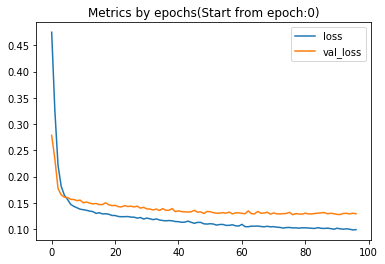

In [72]:
plot_history(history, ['loss','val_loss'], start_at_epoch=0)

In [81]:
y_pred = np.exp(scalery.inverse_transform(model.predict([x_test_lstm_type, x_test_lstm_pred, x_test]).reshape(-1, 1)))
for a in list(zip(y_pred,y_test))[:40]:
    print(a)

(array([4.2415695], dtype=float32), array([4]))
(array([3.7786784], dtype=float32), array([4]))
(array([1653.0991], dtype=float32), array([2006]))
(array([837.9956], dtype=float32), array([1549]))
(array([1271.9069], dtype=float32), array([1150]))
(array([4.1987686], dtype=float32), array([4]))
(array([4.185467], dtype=float32), array([4]))
(array([1462.4739], dtype=float32), array([2015]))
(array([1653.0991], dtype=float32), array([2312]))
(array([4.179089], dtype=float32), array([3]))
(array([4.74822], dtype=float32), array([4]))
(array([4.2415695], dtype=float32), array([4]))
(array([4.436848], dtype=float32), array([4]))
(array([4.7469635], dtype=float32), array([3]))
(array([1271.9069], dtype=float32), array([1151]))
(array([850.44354], dtype=float32), array([958]))
(array([889.9751], dtype=float32), array([642]))
(array([2.977099], dtype=float32), array([3]))
(array([90.920105], dtype=float32), array([1008]))
(array([3.7786784], dtype=float32), array([3]))
(array([1271.9069], dty

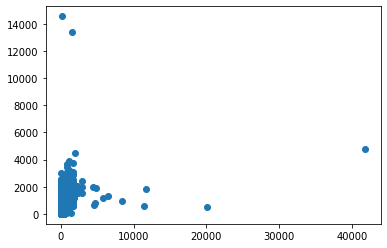

In [82]:
plt.scatter(y_pred,y_test)


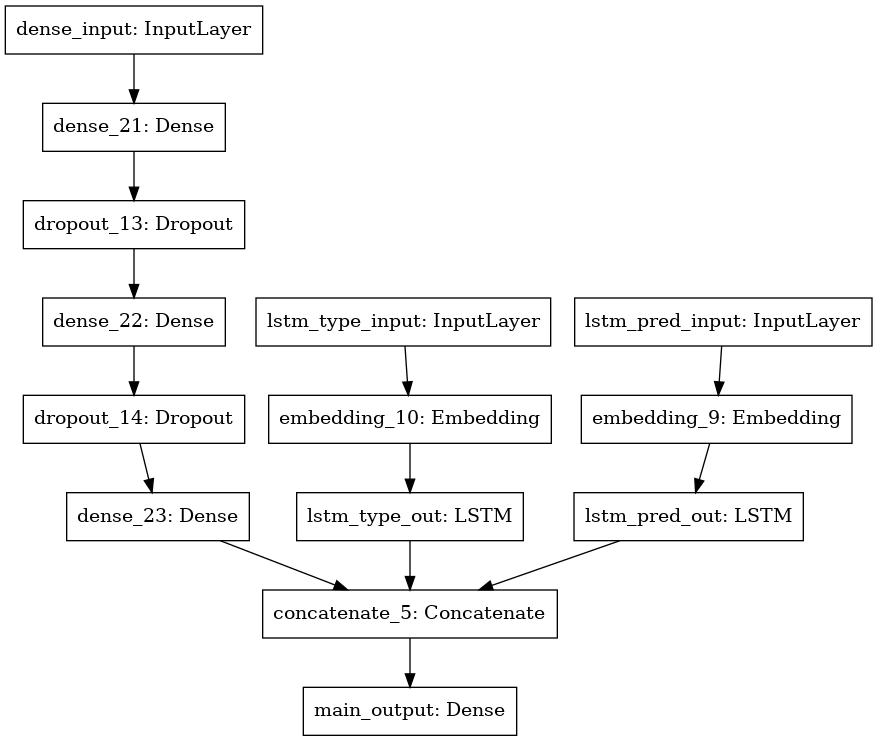

In [84]:
plot_model(model, to_file='model.png')

In [87]:
model2  = build_RNN3(
    num_pred_words,
    EMBEDDING_DIM_PRED,
    EMBEDDING_DIM_TYPES,
    emb_matrix_pred,
    emb_matrix_types,
    lstm_units=32,
    lstm_types_units=5
    )
plot_model(model2, to_file='model2.png')
model2,history = train_rnn_ann(
    model2, 
    [x_train_lstm_pred, x_train],
    y_train_log_std, 
    [x_val_lstm_pred, x_val], 
    y_val_log_std
)

before train: Init time: 1585685971.573
Train on 11759 samples, validate on 2520 samples
Epoch 1/550
11759/11759 [==============================] - 4s 365us/step - loss: 0.4935 - coeff_determination: 0.5020 - rmse: 1.9567 - val_loss: 0.3011 - val_coeff_determination: 0.6966 - val_rmse: 1.6066
Epoch 2/550
11759/11759 [==============================] - 3s 285us/step - loss: 0.3394 - coeff_determination: 0.6564 - rmse: 1.6845 - val_loss: 0.2440 - val_coeff_determination: 0.7543 - val_rmse: 1.4890
Epoch 3/550
11759/11759 [==============================] - 3s 284us/step - loss: 0.2648 - coeff_determination: 0.7323 - rmse: 1.5577 - val_loss: 0.2047 - val_coeff_determination: 0.7938 - val_rmse: 1.4420
Epoch 4/550
11759/11759 [==============================] - 3s 285us/step - loss: 0.2240 - coeff_determination: 0.7741 - rmse: 1.4920 - val_loss: 0.2014 - val_coeff_determination: 0.7970 - val_rmse: 1.4416
Epoch 5/550
11759/11759 [==============================] - 3s 284us/step - loss: 0.2066 - c

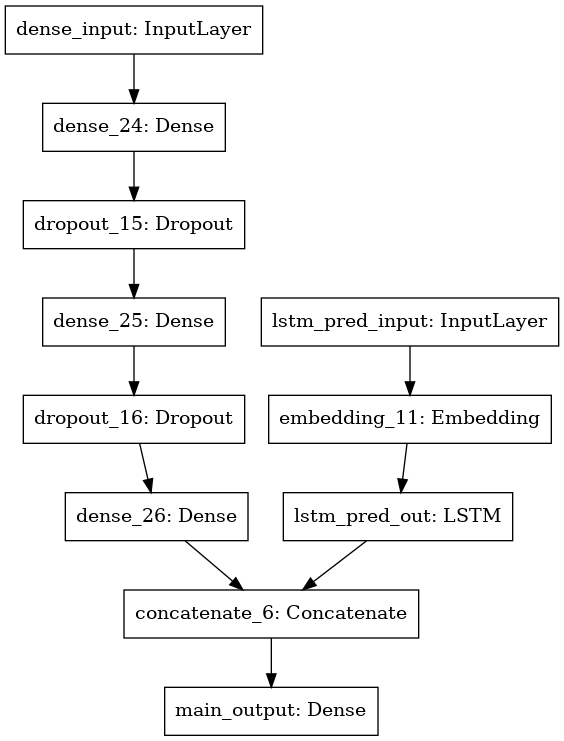

In [88]:
plot_model(model2, to_file='model.png')

In [89]:
get_metrics(model2, scalery,[x_train_lstm_pred, x_train],y_train, label_set="Data")
get_metrics(model2, scalery,[x_val_lstm_pred, x_val],y_val, label_set="Data")
get_metrics(model2, scalery,[x_test_lstm_pred, x_test],y_test, label_set="Data")


RMSE Data 653.479883602672
R2 SCORE Data 0.4273658917905765
RMSE Data 634.5793277802323
R2 SCORE Data 0.4099573023010602
RMSE Data 640.050921477401
R2 SCORE Data 0.41718591893201296


(640.050921477401, 0.41718591893201296)

In [90]:
y_pred = np.exp(scalery.inverse_transform(model2.predict([x_test_lstm_pred, x_test]).reshape(-1, 1)))
for a in list(zip(y_pred,y_test))[:40]:
    print(a)

(array([5.1861644], dtype=float32), array([4]))
(array([4.329108], dtype=float32), array([4]))
(array([1368.4554], dtype=float32), array([2006]))
(array([495.6614], dtype=float32), array([1549]))
(array([1222.3663], dtype=float32), array([1150]))
(array([2.9431815], dtype=float32), array([4]))
(array([5.09594], dtype=float32), array([4]))
(array([994.9835], dtype=float32), array([2015]))
(array([1368.4554], dtype=float32), array([2312]))
(array([6.186955], dtype=float32), array([3]))
(array([5.752227], dtype=float32), array([4]))
(array([5.1861644], dtype=float32), array([4]))
(array([5.342058], dtype=float32), array([4]))
(array([14.111796], dtype=float32), array([3]))
(array([1222.3663], dtype=float32), array([1151]))
(array([748.4635], dtype=float32), array([958]))
(array([860.3194], dtype=float32), array([642]))
(array([2.6324553], dtype=float32), array([3]))
(array([47.396603], dtype=float32), array([1008]))
(array([4.329108], dtype=float32), array([3]))
(array([1222.3663], dtype=

In [ ]:
# Set callback functions to early stop training and save the best model so far
def build_train_denseextended(x_train, y_train, x_val, y_val, n1, n2, n3, epochs, optimizer, dropout, verbose=False):
    
    callbacks_best = [EarlyStopping(monitor='val_loss', patience=20),
                      ModelCheckpoint(filepath='models_newdata/bestm_newdata.h5'.format(n1,n2,n3),
                                      monitor='val_loss', save_best_only=True
                                     )]

    model = Sequential()
    model.add(Dense(n1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(n3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', coeff_determination, rmse])
    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))
    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=120,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_best,
                    verbose=verbose
                     )
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0, 3)))
    print(model.summary())

    return model, history, round(t1-t0, 3)

In [293]:
optimizer = SGD(learning_rate=0.001,momentum=0.2)
model3, history3,tiempo3 = build_train_ann(
    x_train2, y_train_log_std,
    x_val2, y_val_log_std,
    260, 300,240,
    550, 
    optimizer, 
    dropout=0.25,
    verbose=True
)

before train: Init time: 1585693910.071
Train on 11759 samples, validate on 2520 samples
Epoch 1/550
11759/11759 [==============================] - 1s 92us/step - loss: 0.8236 - mae: 0.8683 - coeff_determination: 0.1704 - rmse: 2.4634 - val_loss: 0.6377 - val_mae: 0.7376 - val_coeff_determination: 0.3584 - val_rmse: 2.1902
Epoch 2/550
11759/11759 [==============================] - 1s 64us/step - loss: 0.6380 - mae: 0.7230 - coeff_determination: 0.3579 - rmse: 2.1818 - val_loss: 0.5291 - val_mae: 0.6187 - val_coeff_determination: 0.4674 - val_rmse: 2.0039
Epoch 3/550
11759/11759 [==============================] - 1s 64us/step - loss: 0.5649 - mae: 0.6540 - coeff_determination: 0.4300 - rmse: 2.0647 - val_loss: 0.4844 - val_mae: 0.5677 - val_coeff_determination: 0.5123 - val_rmse: 1.9275
Epoch 4/550
11759/11759 [==============================] - 1s 64us/step - loss: 0.5266 - mae: 0.6165 - coeff_determination: 0.4681 - rmse: 2.0032 - val_loss: 0.4545 - val_mae: 0.5334 - val_coeff_determin

In [291]:
get_metrics(model3, scalery,x_train2, y_train, label_set="Data")
get_metrics(model3, scalery,x_val2, y_val, label_set="Data")
get_metrics(model3, scalery,x_test2, y_test, label_set="Data")


RMSE Data 612.2883903579144
R2 SCORE Data 0.4972815593402409
RMSE Data 616.9509272005891
R2 SCORE Data 0.4422843365156294
RMSE Data 629.965817530404
R2 SCORE Data 0.4354076992113063


(629.965817530404, 0.4354076992113063)